In [65]:
import tensorflow as tf
from tensorflow.keras import layers, Model, applications
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
import nlpaug.augmenter.word as naw
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import os
import sys
from sklearn.model_selection import train_test_split

In [69]:
# Аугментация текста
def augment_technical_text(text, n_variations=3):
    variations = []
    
    # Базовая замена терминов
    replacements = {
        "электродвигатель": ["двигатель", "мотор", "электрическая машина"],
        "трехфазный": ["3-фазный", "трёхфазный"],
        "АИР": ["АИР", "AIR", "АИР"],
        "кВт": ["кВт", "киловатт", "kW"],
        "В": ["В", "вольт", "V"],
        "380В": ["380V", "380 В", "380 вольт"],
        "400В": ["400V", "400 В", "400 вольт"],
        "трехфазный": ["трехфазный", "3-фазный"],
        "асинхронный": ["асинхронный", "индукционный"],
        "IM 1081": ["исполнение IM1081", "монтажное исполнение 1081"],
        "IE2": ["класс энергоэффективности IE2", "стандарт IE2"]
    }
    
    for _ in range(n_variations):
        new_text = text
        for _ in range(random.randint(2, 3)):
            for term, options in replacements.items():
                if term in new_text:
                    new_text = new_text.replace(term, random.choice(options), 1)
                    break
        
        if random.random() < 0.3:
            parts = new_text.split()
            param_indices = [i for i, part in enumerate(parts) 
                            if any(char.isdigit() for char in part) and 
                            any(char.isalpha() for char in part)]
            
            if len(param_indices) >= 2:
                i, j = random.sample(param_indices, 2)
                parts[i], parts[j] = parts[j], parts[i]
                new_text = " ".join(parts)
        
        variations.append(new_text)
    
    return variations

In [70]:
# Аугментация изображений
def augment_images(image_paths, output_dir, n_samples=5):
    os.makedirs(output_dir, exist_ok=True)
    datagen = ImageDataGenerator(
        rotation_range=8,
        width_shift_range=0.05,
        height_shift_range=0.05,
        brightness_range=[0.9, 1.1],
        zoom_range=0.05,
        fill_mode='constant',
        cval=0
    )
    
    new_paths = []
    for path in image_paths:
        try:
            img = load_img(path)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            
            prefix = os.path.splitext(os.path.basename(path))[0]
            for j in range(n_samples):
                for batch in datagen.flow(img_array, batch_size=1):
                    aug_img = batch[0].astype('uint8')
                    new_path = os.path.join(output_dir, f"{prefix}_aug_{j}.jpg")
                    save_img(new_path, aug_img)
                    new_paths.append(new_path)
                    break
        except Exception as e:
            print(f"Ошибка обработки {path}: {str(e)}")
            # Добавляем оригинальный путь как заглушку
            new_paths.extend([path] * n_samples)
    
    return new_paths


In [71]:
# Аугментация числовых данных
def augment_numeric_data(df, columns, n_samples=5):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[columns])
    
    # Используем более простую генерацию если данных мало
    if len(df) < 10:
        synthetic = []
        for _ in range(len(df) * n_samples):
            sample = df[columns].sample(1).values[0]
            # Добавляем небольшой шум
            # noisy_sample = sample * np.random.uniform(0.95, 1.05, len(sample))
            synthetic.append(sample)
        synthetic = np.array(synthetic)
    else:
        # KDE для более крупных датасетов
        from sklearn.neighbors import KernelDensity
        kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
        kde.fit(scaled)
        synthetic = kde.sample(len(df) * n_samples)
        synthetic = scaler.inverse_transform(synthetic)
    
    return pd.DataFrame(synthetic, columns=columns)

In [72]:
# Создание синтетического датасета
def create_synthetic_dataset(original_df, n_samples=5):
    # Аугментация числовых данных
    numeric_cols = ['segment', 'magnitude', 'engine_cost']
    synthetic_numeric = augment_numeric_data(original_df, numeric_cols, n_samples)
    
    # Аугментация текста
    synthetic_text = []
    for text in original_df['marking_equipment']:
        synthetic_text.extend(augment_technical_text(text, n_variations=n_samples))
    
    # Аугментация изображений
    output_aug_dir = "C:\\Users\\gabde\\Downloads\\augmented_images"
    synthetic_image_paths = augment_images(original_df['image_path'], output_aug_dir, n_samples)
    
    # Создание полного датасета
    synthetic_df = pd.DataFrame({
        'segment': synthetic_numeric['segment'],
        'magnitude': synthetic_numeric['magnitude'],
        'engine_cost': synthetic_numeric['engine_cost'],
        'marking_equipment': synthetic_text,
        'image_path': synthetic_image_paths
    })
    
    # Генерация целевой переменной с учетом шума
    synthetic_df['sum'] = synthetic_df['engine_cost'] * np.random.uniform(1.2, 2.0, len(synthetic_df))
    
    return synthetic_df

In [73]:
# Создание и сохранение расширенного датасета
original_df = pd.read_csv("C:\\Users\\gabde\\Downloads\\db.csv")

# Приведение полей к числовому значению
original_df['engine_cost'] = original_df['engine_cost'].str.replace(',', '.', regex=False)
original_df['engine_cost'] = original_df['engine_cost'].astype('float32')

original_df['sum'] = original_df['sum'].str.replace(',', '.', regex=False)
original_df['sum'] = original_df['sum'].astype('float32')

# Подстановка пути к изображениям
image_dir = "C:\\Users\\gabde\\Downloads\\"
train_image_paths = []
total = len(original_df['image_path'])

for i, img_id in enumerate(original_df['image_path']):
    sys.stdout.write(f"\rProcessing {i+1}/{total}")
    sys.stdout.flush()
    
    img_path = os.path.join(image_dir, f"{img_id}")
    print(img_path)
    if os.path.exists(img_path):
        train_image_paths.append(img_path)
    else:
        train_image_paths.append(None)

original_df['image_path'] = train_image_paths
print("\nDone!")

# Синтез данных
synthetic_df = create_synthetic_dataset(original_df, n_samples=10)  # 10x увеличение

# Сохранение результата
synthetic_df.to_csv("C:\\Users\\gabde\\Downloads\\synthetic_db.csv", index=False)
print(f"Создан синтетический датасет с {len(synthetic_df)} записями")

Processing 1/24C:\Users\gabde\Downloads\1_1.jpg
Processing 2/24C:\Users\gabde\Downloads\1_1.jpg
Processing 3/24C:\Users\gabde\Downloads\1_1.jpg
Processing 4/24C:\Users\gabde\Downloads\1_1.jpg
Processing 5/24C:\Users\gabde\Downloads\1_1.jpg
Processing 6/24C:\Users\gabde\Downloads\1_1.jpg
Processing 7/24C:\Users\gabde\Downloads\1_1.jpg
Processing 8/24C:\Users\gabde\Downloads\1_1.jpg
Processing 9/24C:\Users\gabde\Downloads\1_1.jpg
Processing 10/24C:\Users\gabde\Downloads\2_2.jpg
Processing 11/24C:\Users\gabde\Downloads\2_2.jpg
Processing 12/24C:\Users\gabde\Downloads\2_2.jpg
Processing 13/24C:\Users\gabde\Downloads\2_2.jpg
Processing 14/24C:\Users\gabde\Downloads\2_2.jpg
Processing 15/24C:\Users\gabde\Downloads\2_2.jpg
Processing 16/24C:\Users\gabde\Downloads\2_2.jpg
Processing 17/24C:\Users\gabde\Downloads\2_2.jpg
Processing 18/24C:\Users\gabde\Downloads\2_2.jpg
Processing 19/24C:\Users\gabde\Downloads\3_2.jpg
Processing 20/24C:\Users\gabde\Downloads\3_2.jpg
Processing 21/24C:\Users\gabd

In [74]:
synthetic_df

,segment,magnitude,engine_cost,marking_equipment,image_path,sum
0,3.162285,3.134651,149401.743146,Электродвигатель 3-фазный АИР 100L4 380В 4кВт ...,C:\Users\gabde\Downloads\augmented_images\1_1_...,294359.669368
1,1.918827,2.877293,64822.867114,Электродвигатель 3-фазный AIR 4кВт 380В 100L4 ...,C:\Users\gabde\Downloads\augmented_images\1_1_...,86674.552491
2,2.703589,1.885364,119036.871741,Электродвигатель 3-фазный AIR 100L4 380В 4kW 1...,C:\Users\gabde\Downloads\augmented_images\1_1_...,154264.913317
3,1.266791,2.842242,61954.556128,Электродвигатель 3-фазный AIR 100L4 380В 4кВт ...,C:\Users\gabde\Downloads\augmented_images\1_1_...,90678.553272
4,1.970568,0.709632,25078.189116,Электродвигатель 3-фазный АИР 100L4 380В 4кВт ...,C:\Users\gabde\Downloads\augmented_images\1_1_...,48922.377255
...,...,...,...,...,...,...
235,0.935373,2.953744,73986.465553,Электродвигатель Siemens 400V 1LE1502-2BA23-4A...,C:\Users\gabde\Downloads\augmented_images\3_2_...,97793.345917
236,1.072118,2.029506,46629.503855,Электродвигатель Siemens 1LE1502-2BA23-4AB4-Z ...,C:\Users\gabde\Downloads\augmented_images\3_2_...,75873.535669
237,1.138816,3.305497,80757.215287,Электродвигатель Siemens 400V 1LE1502-2BA23-4A...,C:\Users\gabde\Downloads\augmented_images\3_2_...,142418.713190
238,2.933434,0.966350,45971.977979,Электродвигатель Siemens 45кВт 400В 1LE1502-2B...,C:\Users\gabde\Downloads\augmented_images\3_2_...,81485.731010


In [75]:
# 1. Числовой ввод (segment, magnitude, engine_cost)
numeric_input = layers.Input(shape=(3,), name='numeric_input')
numeric_features = layers.Dense(32, activation='relu')(numeric_input)

In [76]:
# 2. Текстовый ввод (marking_equipment)
text_input = layers.Input(shape=(1,), dtype=tf.string, name='text_input')
text_vectorizer = TextVectorization(max_tokens=500, output_sequence_length=50)
text_vectorizer.adapt(train_df['marking_equipment'])
text_features = text_vectorizer(text_input)
text_features = layers.Embedding(input_dim=500, output_dim=64)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)

In [77]:
# 3. Изображения (image_path)
image_input = layers.Input(shape=(224, 224, 3), name='image_input')
base_cnn = applications.MobileNetV2(weights='imagenet', include_top=False)
image_features = base_cnn(image_input)
image_features = layers.GlobalAveragePooling2D()(image_features)

C:\Users\gabde\AppData\Local\Temp\ipykernel_12624\3870303925.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_cnn = applications.MobileNetV2(weights='imagenet', include_top=False)


In [78]:
# Объединение всех модальностей
merged = layers.Concatenate()([numeric_features, text_features, image_features])
merged = layers.Dense(128, activation='relu')(merged)
output = layers.Dense(1, name='output')(merged)  # Регрессия для sum

model = Model(
    inputs=[numeric_input, text_input, image_input],
    outputs=output
)

model.compile(
    optimizer='adam',
    loss='mse',  # MSE для регрессии
    metrics=['mae']
)

In [79]:
def load_and_preprocess_image(path, target_size=(224, 224)):
    img = load_img(path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    return img_array / 255.0  # Нормализация

image_data = np.array([load_and_preprocess_image(path) for path in train_df['image_path']])

In [80]:
vectorizer = TextVectorization(max_tokens=1000, output_sequence_length=20)
vectorizer.adapt(train_df['marking_equipment'])
vectorized_text_data = vectorizer(train_df['marking_equipment'])

In [83]:
# Загрузка синтетического датасета
train_df = pd.read_csv("C:\\Users\\gabde\\Downloads\\synthetic_db.csv")

# Нормализация числовых данных
scaler = StandardScaler()
numeric_data = scaler.fit_transform(train_df[['segment', 'magnitude', 'engine_cost']])

image_data = np.array([load_and_preprocess_image(path) for path in train_df['image_path']])
text_data = train_df['marking_equipment'].values
y = train_df['sum']

indices = np.arange(len(y))
train_indices, test_indices = train_test_split(
    indices, 
    test_size=0.2, 
    random_state=42
)

X_train = {
    'numeric_input': numeric_data[train_indices],
    'text_input': text_data[train_indices],
    'image_input': image_data[train_indices]
}

X_test = {
    'numeric_input': numeric_data[test_indices],
    'text_input': text_data[test_indices],
    'image_input': image_data[test_indices]
}

y_train = y[train_indices]
y_test = y[test_indices]

# Обучение модели на расширенном датасете
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 12600601600.0000 - mae: 100070.8047 - val_loss: 17174392832.0000 - val_mae: 110294.7969
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 14691788800.0000 - mae: 105920.1875 - val_loss: 17156656128.0000 - val_mae: 110214.6641
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 16086903808.0000 - mae: 110613.6016 - val_loss: 17139637248.0000 - val_mae: 110136.3594
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 14621764608.0000 - mae: 106073.6875 - val_loss: 17121313792.0000 - val_mae: 110052.5156
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 14802181120.0000 - mae: 107298.5156 - val_loss: 17090270208.0000 - val_mae: 109908.3438
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 12572169216.0000 - mae: 100024.9375 - val_loss: 17067668480.0000 - val_mae: 109802.5234
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 14165020672.0000 - mae: 105858.9219 - val_loss: 17027875840.0000 - val_ma

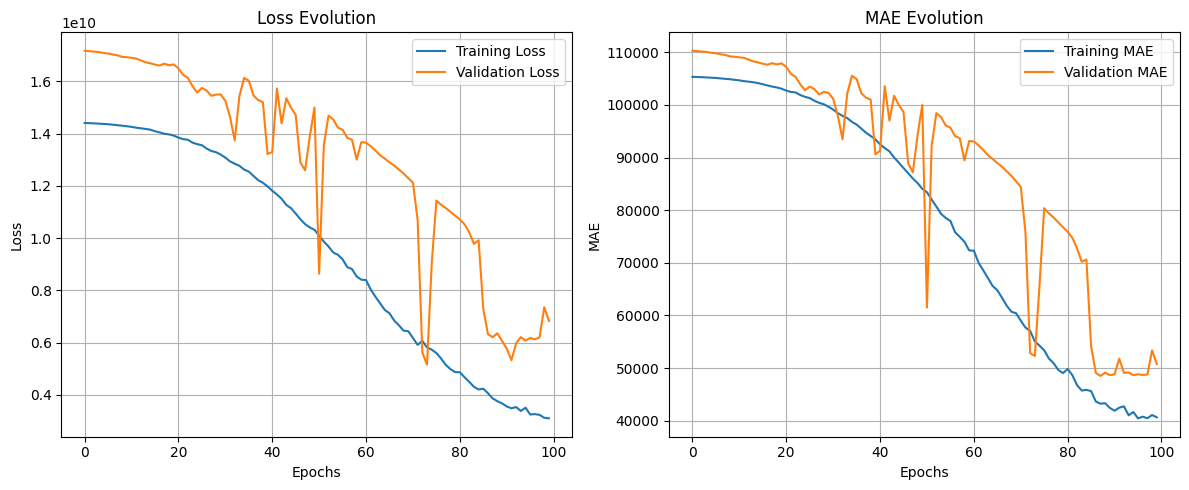

In [90]:
plot_training_history(history)

In [58]:
def plot_training_history(history):
    # Потери (Loss)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # MAE (Mean Absolute Error)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()